# 构建一个检索增强生成（RAG）应用程序：第一部分
介绍 RAG 并讲解一个最小的实现

这里我们专注于非结构化数据的问答

In [1]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph



Note: you may need to restart the kernel to use updated packages.


In [2]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


In [3]:
import getpass
import os

if not os.environ.get("DEEPSEEK_API_KEY"):
  os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter API key for DeepSeek: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

Enter API key for DeepSeek:  ········


In [4]:
import getpass
import os

# 设置阿里云API密钥（替换OpenAI的）
if not os.environ.get("DASHSCOPE_API_KEY"):
    os.environ["DASHSCOPE_API_KEY"] = getpass.getpass("Enter API key for Alibaba Cloud DashScope: ")

# 导入阿里云的嵌入模型
from langchain.embeddings import DashScopeEmbeddings

# 初始化阿里云嵌入模型
embeddings = DashScopeEmbeddings(model="text-embedding-v4")

Enter API key for Alibaba Cloud DashScope:  ········


In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [6]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43047


In [7]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [9]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['d14c729f-134f-44a8-9940-810b4e7e5bcd', '92502ab0-c1e5-4062-b6b3-c5fad747b56b', 'ca23e4e0-f364-44ea-98b7-e600b6939d31']


In [12]:
from langchain import hub

# N.B. for non-US LangSmith endpoints, you may need to specify
# api_url="https://api.smith.langchain.com" in hub.pull.
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


In [13]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [14]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [15]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

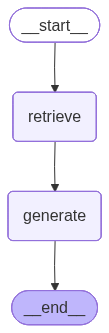

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='ca23e4e0-f364-44ea-98b7-e600b6939d31', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth

In [19]:
for step in graph.stream( # 流式传输
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='ca23e4e0-f364-44ea-98b7-e600b6939d31', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 1638}, page_content='Component One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can

In [21]:
for message, metadata in graph.stream( # 流失token
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| decomposition| is| a| technique| used| by| AI| agents| to| break| down| complex| tasks| into| smaller|,| more| manageable| steps|.| It| can| be| achieved| through| methods| like| Chain| of| Thought| prompting|,| which| instruct|s| a| model| to| "|think| step| by| step|,"| or| by| using| task|-specific| instructions| and| human| input|.| This| process| helps| in| planning| and| interpreting| the| model|'s| approach| to| solving| a| problem|.||

对于异步，和之前的类似

In [22]:
# 查询分析 利用模型从原始用户输入中转换或构建优化的搜索查询。
# 我们可以轻松地将查询分析步骤整合到我们的应用程序中。为了说明目的，让我们向向量存储中的文档添加一些元数据。
# 我们将向文档添加一些（人为设计的）部分，以便稍后进行过滤。
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'start_index': 8,
 'section': 'beginning'}

In [23]:
# 使用一个简单的 InMemoryVectorStore，因为我们将使用它的一些特定功能（即，元数据过滤）

from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [24]:
# 让我们定义搜索查询的 schema。我们将为此目的使用 结构化输出。
# 在这里，我们定义一个查询包含一个字符串查询和一个文档部分（可以是“开头”、“中间”或“结尾”），
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [25]:
# 向 LangGraph 应用程序添加一个步骤，以从用户的原始输入中生成查询
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [26]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='22bfc847-d5c2-44f8-95a2-2119045e8bc4', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 31986, 'section': 'end'}, page_content='},\n  {\n    "role": "user",\n    "content": "{{There are 10 levels in total. The main character is a plumber named Mario, who can walk and jump. It is a classical platform game just like Super Mario. The main character moves from left to right, trying to get to the destination, where there are many obstacles and attacks from enemies in the process.}}\\n\\nIs anything else unclear? If yes, only answer in the form:\\n{remaining unclear areas} remaining questions.\\n{Next question}\\nIf everything is sufficiently clear, only answer \\"Nothing more to clarify.\\"."\n  },\n  {\n    "role": "assistant",\n    "content": "Remaining unclear areas: 2 remaining questions.\\nCan you provide mor